In [1]:
!pip install yfinance
!pip install pandas-datareader

import datetime as dt
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
plt.style.use('fivethirtyeight')
my_ticker = 'AAPL'
days_train = 30
start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime(2023, 1, 1)
# The last day is not included

In [3]:
# 1st way
df = yf.download(my_ticker, start=start_date, end=end_date)

# 2nd way
# df = web.DataReader(my_ticker, data_source='yahoo', start=start_date, end=end_date)

# 3rd way
# yf.pdr_override()
# df = pdr.get_data_yahoo(my_ticker, start=start_date, end=end_date)

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.922568,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.925304,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.472994,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.399737,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.205501,1523816000
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400


In [4]:
df.shape

(3777, 6)

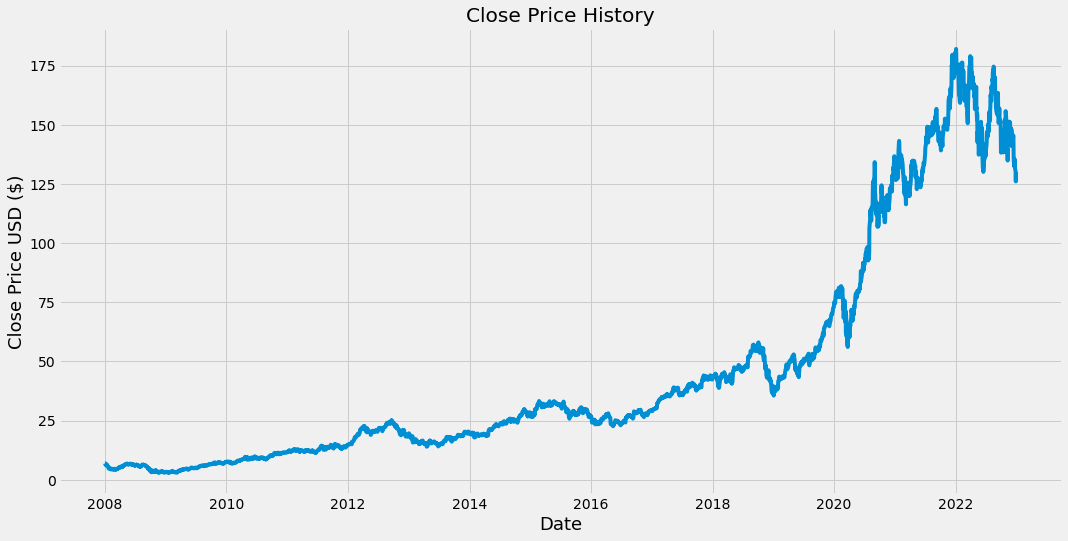

In [5]:
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
data = df.filter(['Close'])
dataset = data.values
# Training set would be 80% of the data
# Other 20% for testing set
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

3022

In [7]:
# create a new instance of the MinMaxScaler class with a feature range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# normalize the dataset using the scaler's fit_transform method
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02324395],
       [0.02326189],
       [0.02029661],
       ...,
       [0.68769731],
       [0.70761728],
       [0.70940278]])

In [8]:
# Select the first training_data_len rows of the scaled_data array to use as training data
# 20% of dataset
train_data = scaled_data[0:training_data_len, :]

# Create empty arrays to store the input x and output y data for the model
x_train = []
y_train = []

# Iterate over the train_data array, creating training examples of length days_train
# days_train is set to the number of days of historical stock price data you want to use to train your LSTM model
for i in range(days_train, len(train_data)):
    x_train.append(train_data[i - days_train: i, 0])
    y_train.append(train_data[i, 0])
    # To understand what happening, let's print the input and output arrays for the first three training examples
    if i <= days_train + 2:
        print(x_train)
        print(y_train)
        print()

[array([0.02324395, 0.02326189, 0.02029661, 0.01981635, 0.01854295,
       0.02016708, 0.01989207, 0.01882991, 0.02004353, 0.01810255,
       0.01622932, 0.01647841, 0.01657208, 0.0154322 , 0.01213014,
       0.01143864, 0.01032467, 0.01032467, 0.01062956, 0.0107571 ,
       0.01139082, 0.01106997, 0.01065149, 0.01019514, 0.00872844,
       0.00857699, 0.00942193, 0.01021307, 0.00929838, 0.01020311])]
[0.009816506328808655]

[array([0.02324395, 0.02326189, 0.02029661, 0.01981635, 0.01854295,
       0.02016708, 0.01989207, 0.01882991, 0.02004353, 0.01810255,
       0.01622932, 0.01647841, 0.01657208, 0.0154322 , 0.01213014,
       0.01143864, 0.01032467, 0.01032467, 0.01062956, 0.0107571 ,
       0.01139082, 0.01106997, 0.01065149, 0.01019514, 0.00872844,
       0.00857699, 0.00942193, 0.01021307, 0.00929838, 0.01020311]), array([0.02326189, 0.02029661, 0.01981635, 0.01854295, 0.02016708,
       0.01989207, 0.01882991, 0.02004353, 0.01810255, 0.01622932,
       0.01647841, 0.01657208, 0

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape the x_train array to add a third dimension for the single feature (closing price)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(2992, 30, 1)

In [11]:
#initializing the model 
model = Sequential()

# First Input layer and LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# model.add(LSTM(units=50,return_sequences=True))

# we won't use return sequence true in last layers as we don't want to use the previous output
model.add(LSTM(units=50))

# model.add(Dense(25))

# Output layer, we won't pass any activation as it's a continuous value model
model.add(Dense(units=1))

In [12]:
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))

In [13]:
# # Initialize the model
# model = Sequential()

# # Add the first input layer and LSTM layer
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# model.add(LSTM(units=50))

# # Add the output layer with a linear activation function
# model.add(Dense(units=1, activation='tanh'))

# # Set the optimizer, loss function, and metrics
# optimizer = Adam(learning_rate=0.001)
# loss = 'mean_squared_error'
# metrics = ['mean_squared_error', 'mean_absolute_error']

In [14]:
# Use mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=3)

In [16]:
test_data = scaled_data[training_data_len - days_train:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(days_train, len(test_data)):
    x_test.append(test_data[i - days_train: i, 0])

In [17]:
x_test = np.array(x_test)

In [18]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(755, 30, 1)

In [19]:
def train_and_evaluate(x_train, y_train, x_test, y_test):
    best_rmse = float("inf")
    best_batch_size = -1
    best_history = None
    for batch_size in [2**n for n in range(0, 11)]:
            # Use early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='loss', patience=3)

            # Train the model for the given number of epochs and batch size
            history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1000, callbacks=[early_stopping], verbose=0)

            # Make predictions on the test data and calculate the RMSE
            predictions = model.predict(x_test)
            predictions = scaler.inverse_transform(predictions)
            rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

            # Print the RMSE for this combination of batch size and epochs
            print(f"Batch size: {batch_size}, RMSE: {rmse}")

            # Update the best RMSE and the corresponding batch size and epochs if the current RMSE is less than the best RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_batch_size = batch_size
                best_history = history

    # Print the best combination of batch size and epochs along with the corresponding RMSE
    print(f"Best Batch size: {best_batch_size}, Best RMSE: {best_rmse}")

    return best_history, best_batch_size

history, _ = train_and_evaluate(x_train, y_train, x_test, y_test)

24/24 [==============================] - 1s 4ms/step
Batch size: 1, RMSE: 4.971833792608272
24/24 [==============================] - 0s 3ms/step
Batch size: 2, RMSE: 3.5042912013977343
24/24 [==============================] - 0s 4ms/step
Batch size: 4, RMSE: 3.354566416390778
24/24 [==============================] - 0s 3ms/step
Batch size: 8, RMSE: 3.741046507082066
24/24 [==============================] - 0s 4ms/step
Batch size: 16, RMSE: 3.619705202773622
24/24 [==============================] - 0s 5ms/step
Batch size: 32, RMSE: 3.0880062135096806
24/24 [==============================] - 0s 3ms/step
Batch size: 64, RMSE: 3.025372542301056
24/24 [==============================] - 0s 4ms/step
Batch size: 128, RMSE: 3.140498032153605
24/24 [==============================] - 0s 4ms/step
Batch size: 256, RMSE: 3.077673954184345
24/24 [==============================] - 0s 3ms/step
Batch size: 512, RMSE: 3.133464674324238
24/24 [==============================] - 0s 4ms/step
Batch size: 1024

In [20]:
model.metrics_names

['loss']

In [21]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
len(predictions)

24/24 [==============================] - 0s 4ms/step


755

In [22]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3.1846493107570137

<ipython-input-23-407bfe881fa6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


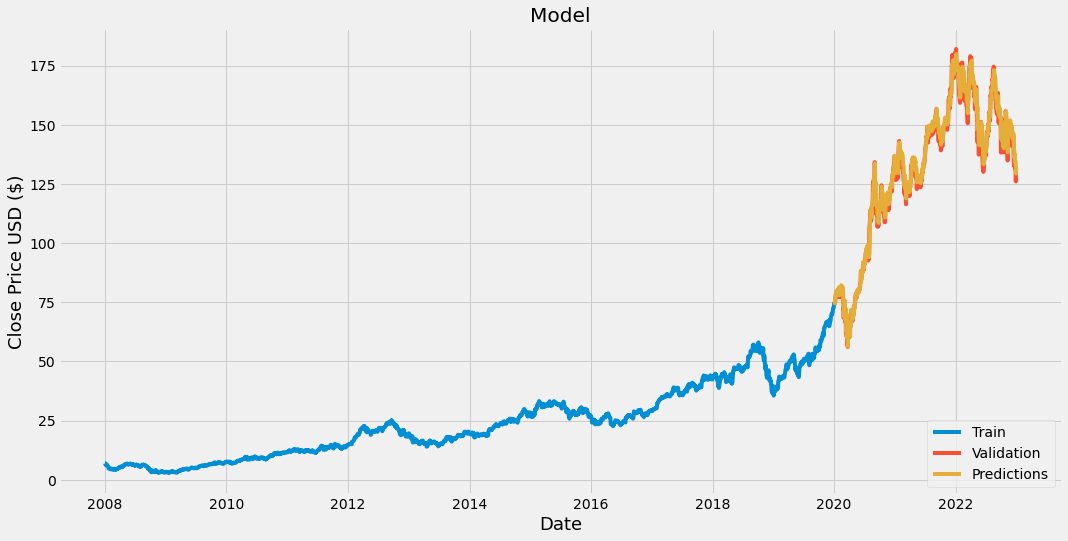

In [23]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [24]:
valid

,Close,Predictions
Date,,
2020-01-03,74.357498,75.251671
2020-01-06,74.949997,74.525703
2020-01-07,74.597504,75.346916
2020-01-08,75.797501,74.962318
2020-01-09,77.407501,76.184662
...,...,...
2022-12-23,131.860001,134.272263
2022-12-27,130.029999,134.414230
2022-12-28,126.040001,132.446274


In [29]:
# Define start and end dates for prediction
# I don't know, but model fails when it reaches one third of predicting days
# So I would like to predict 120 days and I set days_to_predict to 45
days_to_predict = 180
days_to_predict  = int(days_to_predict * 1.5)
start_date_pred = end_date + dt.timedelta(days=1)
end_date_pred = end_date + dt.timedelta(days=days_to_predict)

# Download stock data for prediction period
apple_quote_pred = yf.download(my_ticker, start=start_date_pred, end=end_date_pred)

# Extract close prices and normalize them
close_prices_pred = apple_quote_pred.filter(['Close']).values
close_prices_pred_scaled = scaler.transform(close_prices_pred)

# Create a list to store predicted prices and a counter for successful predictions
predicted_prices = []
num_success = 0

# Use the last 45 days of actual stock prices to predict the next days_to_predict days
for i in range(days_to_predict):
    X_test = close_prices_pred_scaled[i:i+days_train]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
    try:
        pred_price = model.predict(X_test)
        pred_price = scaler.inverse_transform(pred_price)
        predicted_prices.append(pred_price[0][0])
        num_success += 1
    except:
        print(f"Failed to predict day {i+1}.")
        break
    
# Print the predicted prices and number of successful predictions
print(f"Predicted prices: {predicted_prices}")
print(f"Successfully predicted {num_success} out of {days_to_predict} days.")

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 22ms/step
Failed to predict day 34.
Predicted prices: [153.9647, 155.94621, 154.5773, 154.33542, 154.34271, 154.35207, 154.36406, 154.37961, 154.3991, 154.42369, 154.45444, 154.49194, 154.53767, 154.59402, 154.66273, 154.7439, 154.83607, 154.93953, 155.05397, 155.16592, 155.27165, 155.34961, 155.36874, 155.31071, 155.0864, 154.60112, 153.85255, 152.26627, 150.62772, 145.19832, 145.19914, 122.00393, 151.78934]
Successfully predicted 33 out of 270 days.


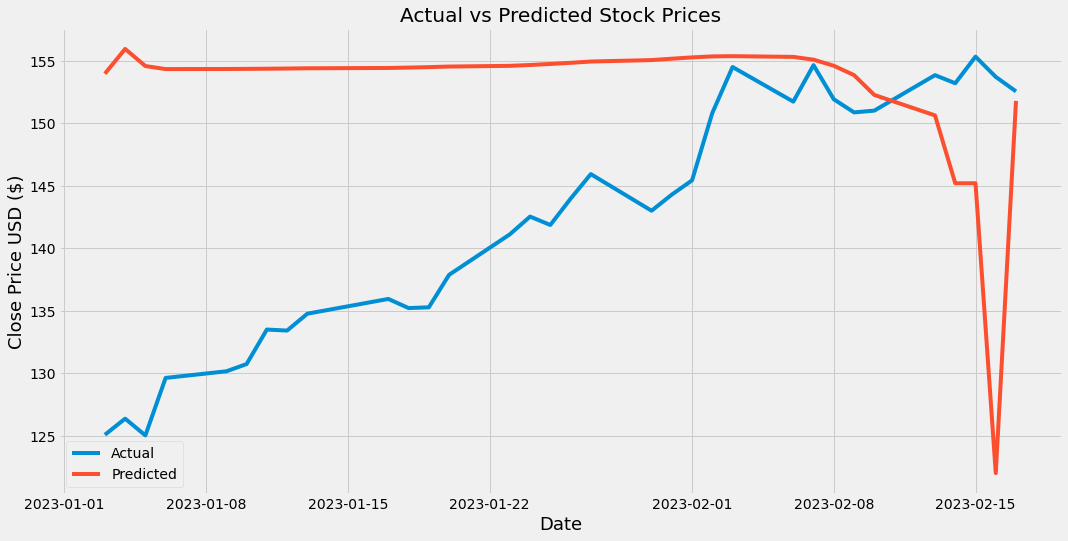

In [30]:
# Plot the actual and predicted stock prices on the same graph
plt.figure(figsize=(16, 8))
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(apple_quote_pred.index, close_prices_pred, label='Actual')
plt.plot(apple_quote_pred.index[-num_success:], predicted_prices, label='Predicted')
plt.legend()
plt.show()